In [2]:
from pathlib import Path
from typing import Dict, List

import numpy as np
import pandas as pd

# Reuse the core column names and thresholds from 02_classify_operation
DATA_PATH = Path("data/4_well_dataset.xlsx")
if not DATA_PATH.exists():
    DATA_PATH = Path("../data/4_well_dataset.xlsx")

INVALID_PLACEHOLDER_THRESHOLD = -900.0  # Handles -999.25 and similar placeholders.

DEPTH_COL = "Depth(m)"
FLOW_COL = "Flow In Pum Avg(lpm)"
SPP_COL = "SPP Avg(bar)"
ANNULAR_COL = "Annular Press(barg)"
TORQUE_COL = "Torque Abs Avg(kN-m)"
WOB_COL = "WOB Avg(mton)"
ROP_COL = "ROP Avg(m/hr)"

MODE_CONFIG_DEFAULT = {
    "spp_valley_frac": 0.9,
    "ap_valley_frac": 0.9,
    "smooth_window": 21,
    "valley_expand_window": 4,
}


def rolling_plateau_reference(series: pd.Series, window: int) -> pd.Series:
    """Rolling-median reference representing the local plateau level."""
    if window <= 1:
        return series
    return series.rolling(window=window, center=True, min_periods=1).median()


def expand_boolean_mask(mask: pd.Series, window: int) -> pd.Series:
    """Expand boolean runs by taking a rolling maximum over the requested window."""
    mask = mask.fillna(False)
    if window <= 1:
        return mask
    expanded = (
        mask.astype(float)
        .rolling(window=window, center=True, min_periods=1)
        .max()
        .fillna(0.0)
        .astype(bool)
    )
    return expanded



In [3]:
def load_well_excel(path: Path, sheet_name: str, well_id: str | None = None) -> pd.DataFrame:
    """Load a single sheet from the Excel file and inject a well_id column."""
    df = pd.read_excel(path, sheet_name=sheet_name)
    df = df.copy()
    df["well_id"] = well_id or sheet_name
    return df


def clean_raw(df_raw: pd.DataFrame, invalid_threshold: float = INVALID_PLACEHOLDER_THRESHOLD) -> pd.DataFrame:
    """Replace placeholder values and drop rows with unrealistically high ROP."""
    df = df_raw.copy()
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    if len(numeric_cols):
        df.loc[:, numeric_cols] = df.loc[:, numeric_cols].mask(df.loc[:, numeric_cols] <= invalid_threshold)

    # Remove rows with ROP above threshold
    if ROP_COL in df.columns:
        df = df[(df[ROP_COL].isna()) | (df[ROP_COL] <= 300)].copy()
    return df


def classify_modes(df_clean: pd.DataFrame, mode_config: dict | None = None) -> pd.DataFrame:
    """Apply the plateau-vs-valley classifier from 02_classify_operation."""
    config = {**MODE_CONFIG_DEFAULT, **(mode_config or {})}
    result = df_clean.copy()

    spp = result[SPP_COL]
    spp_smooth = rolling_plateau_reference(spp, config["smooth_window"])
    result["SPP_smooth"] = spp_smooth
    result["SPP_ratio"] = spp / spp_smooth.replace({0: np.nan})
    spp_valley = (result["SPP_ratio"] < config["spp_valley_frac"]).fillna(False)

    has_annular = ANNULAR_COL in result.columns and result[ANNULAR_COL].notna().any()
    if has_annular:
        ap = result[ANNULAR_COL]
        ap_smooth = rolling_plateau_reference(ap, config["smooth_window"])
        result["AP_smooth"] = ap_smooth
        result["AP_ratio"] = ap / ap_smooth.replace({0: np.nan})
        ap_valley = (result["AP_ratio"] < config["ap_valley_frac"]).fillna(False)
    else:
        result["AP_smooth"] = np.nan
        result["AP_ratio"] = np.nan
        ap_valley = pd.Series(False, index=result.index)

    combined_valley = expand_boolean_mask(
        spp_valley | ap_valley,
        config["valley_expand_window"],
    )

    invalid_mask = spp.isna()

    mode = pd.Series("drill", index=result.index, dtype="object")
    mode.loc[combined_valley] = "low_pressure_event"
    mode.loc[invalid_mask] = "invalid"

    result["mode"] = pd.Categorical(mode, categories=["drill", "low_pressure_event", "invalid"])
    result.attrs["classification_config"] = config
    return result



In [4]:
CORE_DRILL_DEFAULTS = {
    "spp_ratio_bounds": (0.95, 1.05),
    "flow_frac_of_median": 0.85,
    "min_distance_from_low_pressure_m": 5.0,
}


def _distance_to_nearest_low_pressure(depths: pd.Series, low_pressure_mask: pd.Series) -> pd.Series:
    low_depths = depths[low_pressure_mask].to_numpy()
    if low_depths.size == 0:
        return pd.Series(np.inf, index=depths.index, dtype=float)
    depth_values = depths.to_numpy()
    distances = np.abs(depth_values[:, None] - low_depths[None, :]).min(axis=1)
    return pd.Series(distances, index=depths.index, dtype=float)


def add_core_drill_mask(df_modes: pd.DataFrame, params: dict | None = None) -> pd.DataFrame:
    """Mark a stricter drill subset: plateau-level SPP, healthy flow, far from valleys."""
    cfg = {**CORE_DRILL_DEFAULTS, **(params or {})}
    if "mode" not in df_modes.columns or "SPP_ratio" not in df_modes.columns:
        raise ValueError("'mode' and 'SPP_ratio' must be present before adding core drill mask.")

    result = df_modes.copy()

    depth = result[DEPTH_COL]
    mode = result["mode"]
    spp_ratio = result["SPP_ratio"]
    flow = result[FLOW_COL]

    distance_to_lpe = _distance_to_nearest_low_pressure(depth, mode == "low_pressure_event")
    ratio_cond = spp_ratio.between(cfg["spp_ratio_bounds"][0], cfg["spp_ratio_bounds"][1], inclusive="both").fillna(False)
    median_flow = flow.median(skipna=True)
    flow_cond = (flow > (cfg["flow_frac_of_median"] * median_flow)).fillna(False)
    distance_cond = (distance_to_lpe > cfg["min_distance_from_low_pressure_m"]).fillna(False)

    is_core = (mode == "drill") & ratio_cond & flow_cond & distance_cond
    result["distance_to_low_pressure_m"] = distance_to_lpe
    result["is_core_drill"] = is_core
    result.attrs["core_drill_params"] = cfg
    return result


def concat_wells(dfs: List[pd.DataFrame]) -> pd.DataFrame:
    """Concatenate per-well DataFrames after verifying shared schema and well_id presence."""
    if not dfs:
        return pd.DataFrame()
    base_cols = list(dfs[0].columns)
    required_cols = set(base_cols)
    for df in dfs:
        if "well_id" not in df.columns:
            raise ValueError("Each DataFrame must contain a 'well_id' column before concatenation.")
        if set(df.columns) != required_cols:
            diff = required_cols.symmetric_difference(df.columns)
            raise ValueError(f"Column mismatch across wells: {sorted(diff)}")
    combined = pd.concat(dfs, ignore_index=True, sort=False)
    return combined


def make_splits(df_all: pd.DataFrame, strategy: str, params: dict) -> tuple[pd.DataFrame, pd.DataFrame]:
    """Create simple train/test splits for downstream modeling."""
    if "well_id" not in df_all.columns:
        raise ValueError("DataFrame must contain a 'well_id' column before splitting.")

    if strategy == "per_well_depth_split":
        well_id = params["well_id"]
        depth_split = params["depth_split"]
        train_side = params.get("train_side", "above")  # "above" -> train <= split; "below" -> train > split
        target = df_all[df_all["well_id"] == well_id]
        others = df_all[df_all["well_id"] != well_id]
        if train_side == "above":
            train = pd.concat(
                [others, target[target[DEPTH_COL] <= depth_split]],
                ignore_index=True,
                sort=False,
            )
            test = target[target[DEPTH_COL] > depth_split].copy()
        else:
            train = pd.concat(
                [others, target[target[DEPTH_COL] > depth_split]],
                ignore_index=True,
                sort=False,
            )
            test = target[target[DEPTH_COL] <= depth_split].copy()
    elif strategy == "per_well_depth_fraction":
        well_id = params["well_id"]
        frac = params.get("train_frac", 0.8)
        target = df_all[df_all["well_id"] == well_id]
        if target.empty:
            raise ValueError(f"No rows for well_id={well_id}")
        depth_cut = target[DEPTH_COL].quantile(frac)
        train, test = make_splits(
            df_all,
            strategy="per_well_depth_split",
            params={"well_id": well_id, "depth_split": depth_cut, "train_side": "above"},
        )
    elif strategy == "leave_one_well_out":
        holdout = params["holdout_well_id"]
        test = df_all[df_all["well_id"] == holdout].copy()
        train = df_all[df_all["well_id"] != holdout].copy()
    else:
        raise ValueError(f"Unknown strategy '{strategy}'")

    return train, test



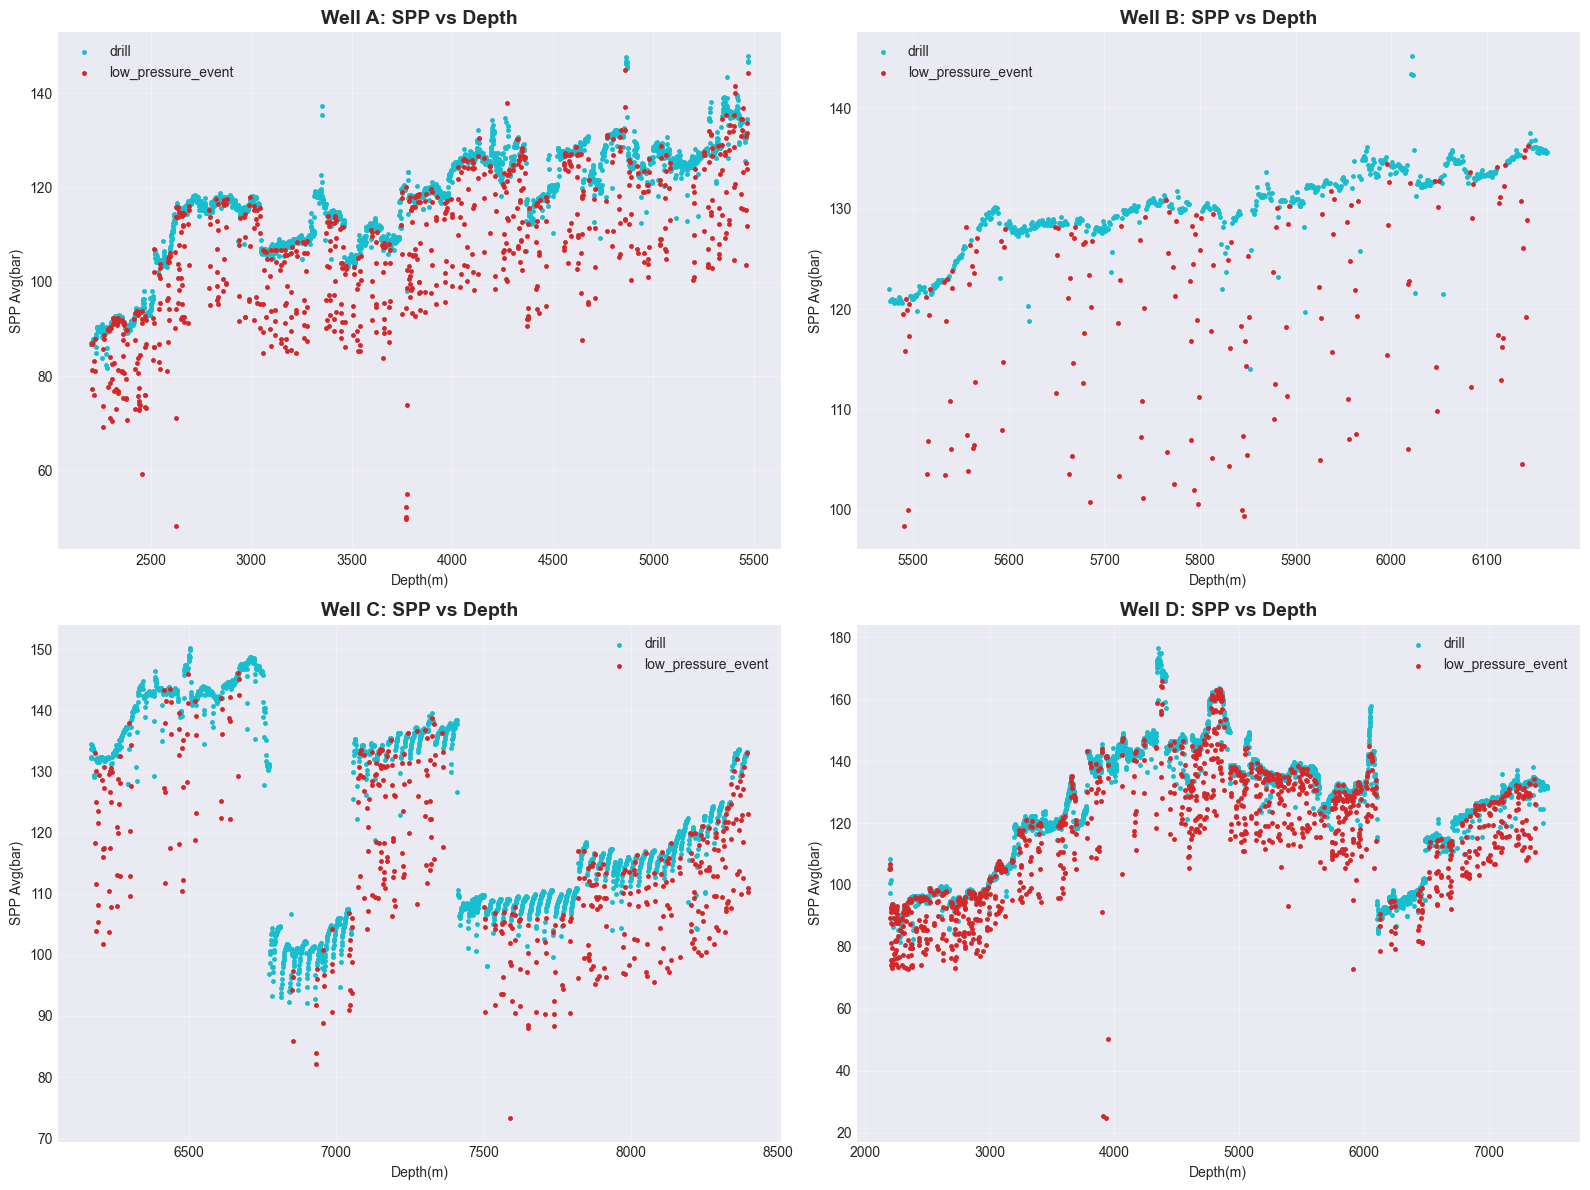

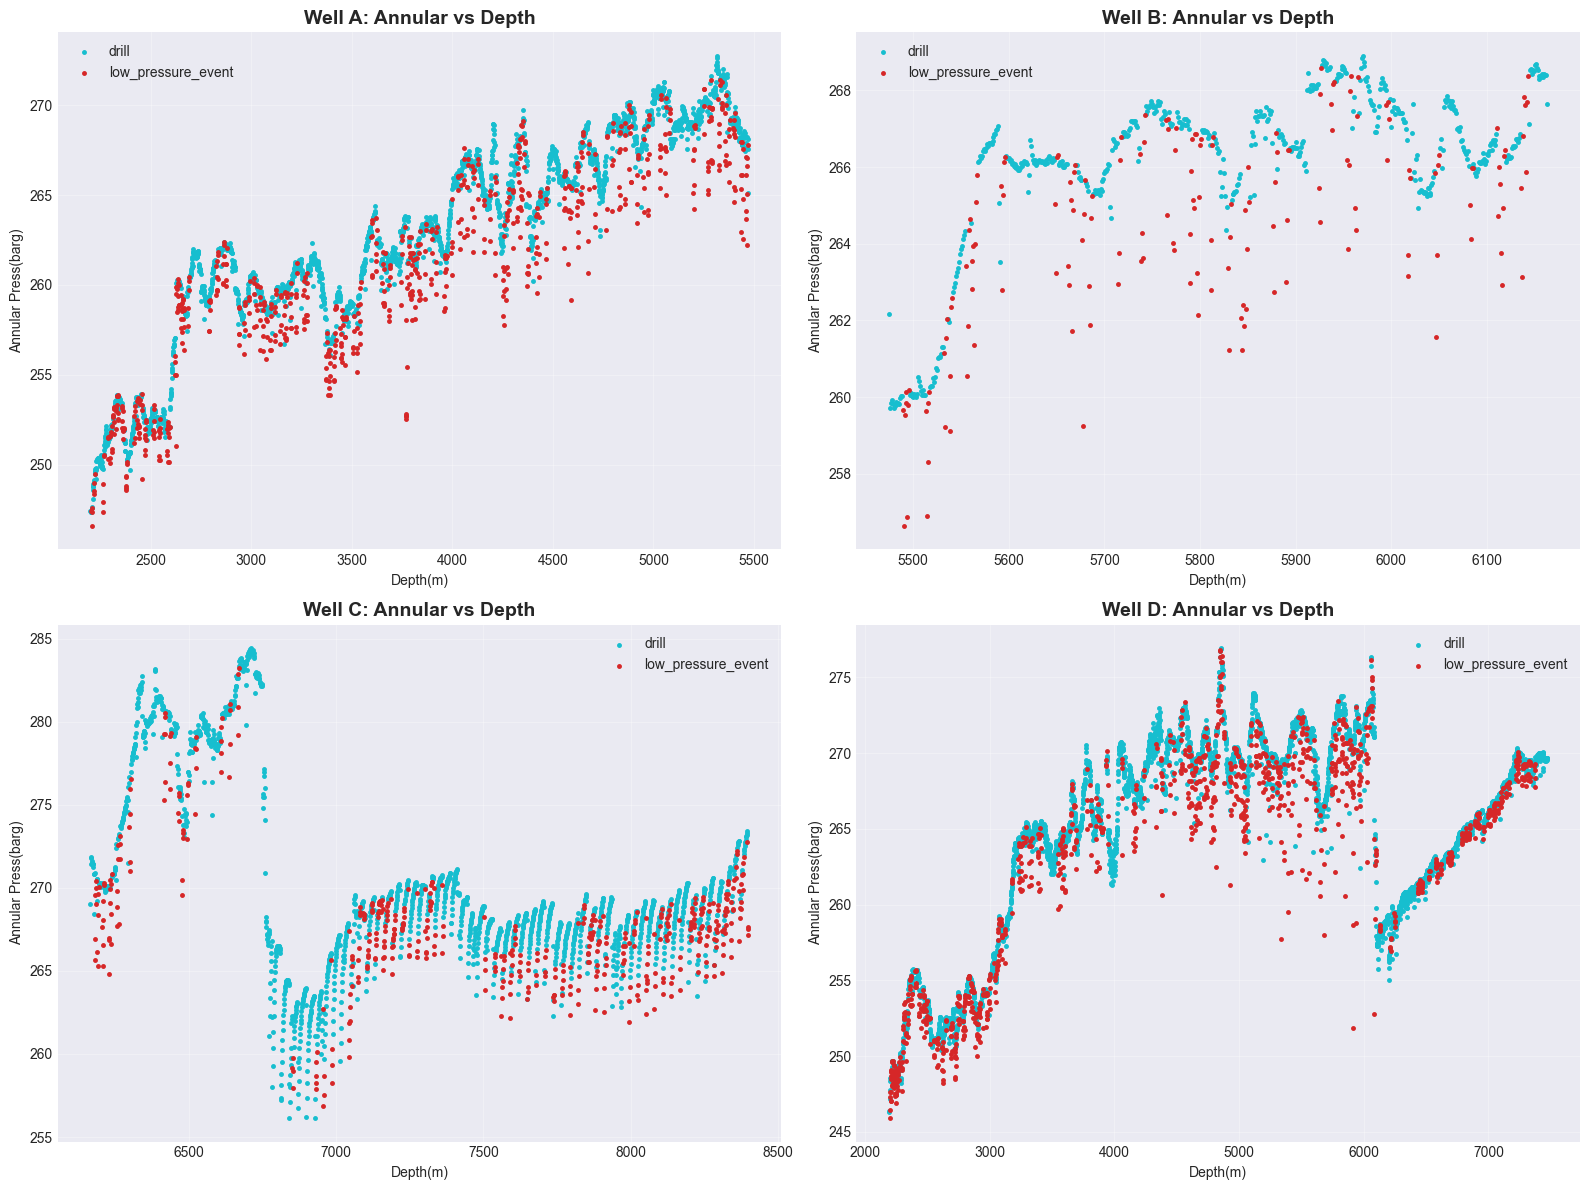

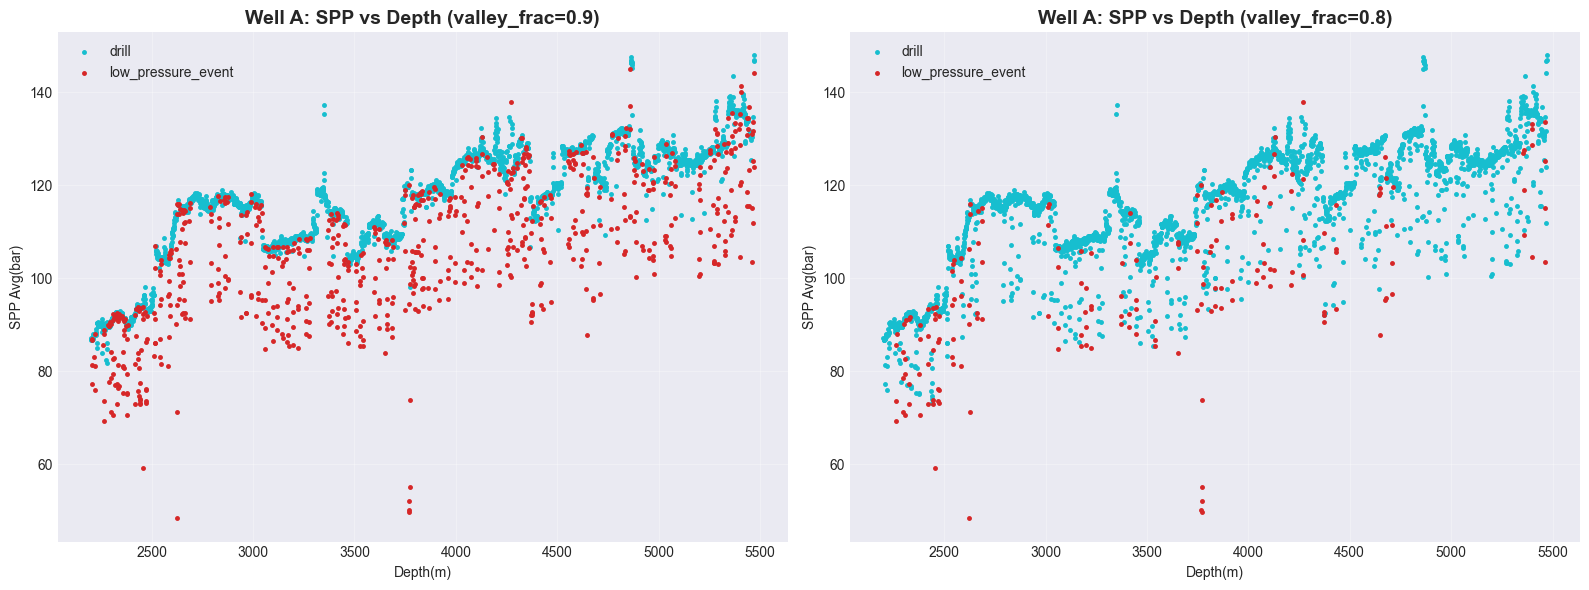

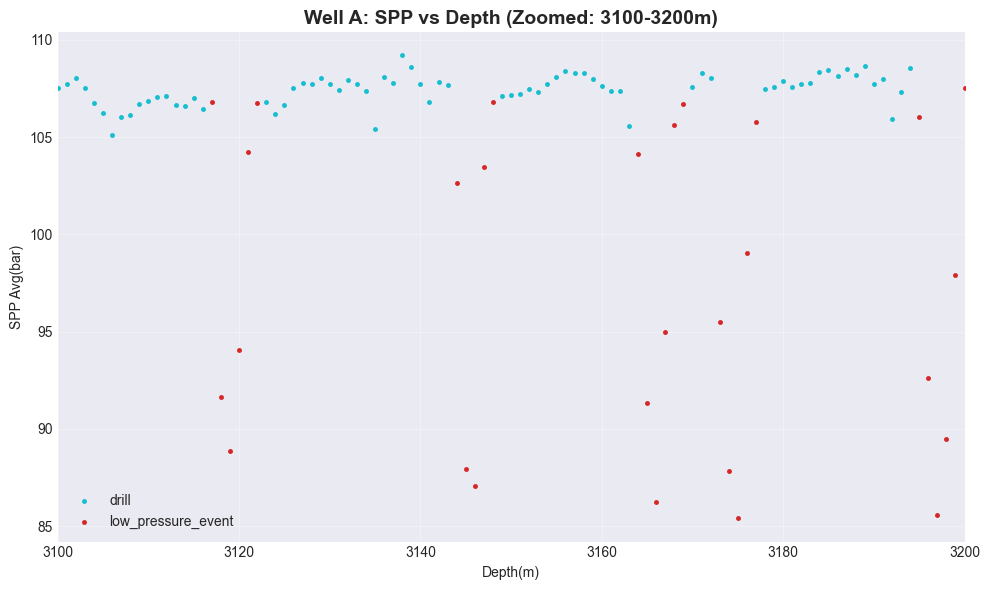

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for better-looking plots
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except Exception:
    try:
        plt.style.use('seaborn-darkgrid')
    except Exception:
        plt.style.use('default')

sns.set_palette("husl")
MODE_COLORS = {"drill": "tab:cyan", "low_pressure_event": "tab:red", "invalid": "tab:gray"}

# Load, clean, classify, add core mask for all wells
raw_wells = pd.read_excel(DATA_PATH, sheet_name=None)
processed_wells: Dict[str, pd.DataFrame] = {}
for well_id, raw_df in raw_wells.items():
    df_raw = load_well_excel(DATA_PATH, sheet_name=well_id, well_id=well_id)
    df_clean = clean_raw(df_raw)
    df_modes = classify_modes(df_clean)
    df_core = add_core_drill_mask(df_modes)
    processed_wells[well_id] = df_core

# Plot SPP vs depth for all wells (2x2 grid), colored by mode
wells_sorted = sorted(processed_wells.keys())
output_dir = Path("../figures/preprocessing")
output_dir.mkdir(parents=True, exist_ok=True)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()
for idx, well_id in enumerate(wells_sorted):
    if idx >= len(axes):
        break
    ax = axes[idx]
    df = processed_wells[well_id]
    if SPP_COL not in df.columns or df[SPP_COL].notna().sum() == 0:
        ax.set_visible(False)
        continue
    for mode, color in MODE_COLORS.items():
        mask = (df["mode"] == mode) & df[SPP_COL].notna()
        if mask.any():
            ax.scatter(
                df.loc[mask, DEPTH_COL],
                df.loc[mask, SPP_COL],
                s=50,
                alpha=1,
                color=color,
                marker='.',
                linewidths=0,
                label=mode,
            )
    ax.set_title(f"Well {well_id}: SPP vs Depth", fontsize=14, fontweight='bold')
    ax.set_xlabel(DEPTH_COL)
    ax.set_ylabel(SPP_COL)
    ax.grid(True, alpha=0.3)
    ax.legend()

# Hide any unused subplots
for ax in axes[len(wells_sorted):]:
    ax.set_visible(False)
fig.tight_layout()
fig.savefig(output_dir / "spp_w_mode_labels.pdf")
plt.show()

# Plot Annular Pressure vs depth for all wells (2x2 grid), colored by mode
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()
for idx, well_id in enumerate(wells_sorted):
    if idx >= len(axes):
        break
    ax = axes[idx]
    df = processed_wells[well_id]
    if ANNULAR_COL not in df.columns or df[ANNULAR_COL].notna().sum() == 0:
        ax.set_visible(False)
        continue
    for mode, color in MODE_COLORS.items():
        mask = (df["mode"] == mode) & df[ANNULAR_COL].notna()
        if mask.any():
            ax.scatter(
                df.loc[mask, DEPTH_COL],
                df.loc[mask, ANNULAR_COL],
                s=50,
                alpha=1,
                color=color,
                marker='.',
                linewidths=0,
                label=mode,
            )
    ax.set_title(f"Well {well_id}: Annular vs Depth", fontsize=14, fontweight='bold')
    ax.set_xlabel(DEPTH_COL)
    ax.set_ylabel(ANNULAR_COL)
    ax.grid(True, alpha=0.3)
    ax.legend()

for ax in axes[len(wells_sorted):]:
    ax.set_visible(False)
fig.tight_layout()
fig.savefig(output_dir / "ap_w_mode_labels.pdf")
plt.show()

# Plot Well A SPP vs depth with different valley_frac values (0.9 and 0.8)
well_a_id = 'A'
if well_a_id in raw_wells.keys():
    df_raw_a = load_well_excel(DATA_PATH, sheet_name=well_a_id, well_id=well_a_id)
    df_clean_a = clean_raw(df_raw_a)
    
    # Classify with valley_frac = 0.9
    df_modes_09 = classify_modes(df_clean_a, mode_config={"spp_valley_frac": 0.9, "ap_valley_frac": 0.9})
    
    # Classify with valley_frac = 0.8
    df_modes_08 = classify_modes(df_clean_a, mode_config={"spp_valley_frac": 0.8, "ap_valley_frac": 0.8})
    
    # Create side-by-side plots
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot with valley_frac = 0.9
    ax = axes[0]
    df = df_modes_09
    if SPP_COL in df.columns and df[SPP_COL].notna().sum() > 0:
        for mode, color in MODE_COLORS.items():
            mask = (df["mode"] == mode) & df[SPP_COL].notna()
            if mask.any():
                ax.scatter(
                    df.loc[mask, DEPTH_COL],
                    df.loc[mask, SPP_COL],
                    s=50,
                    alpha=1,
                    color=color,
                    marker='.',
                    linewidths=0,
                    label=mode,
                )
    ax.set_title(f"Well {well_a_id}: SPP vs Depth (valley_frac=0.9)", fontsize=14, fontweight='bold')
    ax.set_xlabel(DEPTH_COL)
    ax.set_ylabel(SPP_COL)
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    # Plot with valley_frac = 0.8
    ax = axes[1]
    df = df_modes_08
    if SPP_COL in df.columns and df[SPP_COL].notna().sum() > 0:
        for mode, color in MODE_COLORS.items():
            mask = (df["mode"] == mode) & df[SPP_COL].notna()
            if mask.any():
                ax.scatter(
                    df.loc[mask, DEPTH_COL],
                    df.loc[mask, SPP_COL],
                    s=50,
                    alpha=1,
                    color=color,
                    marker='.',
                    linewidths=0,
                    label=mode,
                )
    ax.set_title(f"Well {well_a_id}: SPP vs Depth (valley_frac=0.8)", fontsize=14, fontweight='bold')
    ax.set_xlabel(DEPTH_COL)
    ax.set_ylabel(SPP_COL)
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    fig.tight_layout()
    fig.savefig(output_dir / "well_A_spp_valley_frac_comparison.pdf")
    plt.show()

# Plot Well A SPP vs depth zoomed in between 3100-3200m, colored by mode
well_a_id = 'A'
if well_a_id in processed_wells.keys():
    df = processed_wells[well_a_id]
    
    # Filter for depth range 3100-3200m
    depth_mask = (df[DEPTH_COL] >= 3100) & (df[DEPTH_COL] <= 3200)
    df_zoomed = df[depth_mask].copy()
    
    if SPP_COL in df_zoomed.columns and df_zoomed[SPP_COL].notna().sum() > 0:
        fig, ax = plt.subplots(1, 1, figsize=(10, 6))
        
        for mode, color in MODE_COLORS.items():
            mask = (df_zoomed["mode"] == mode) & df_zoomed[SPP_COL].notna()
            if mask.any():
                ax.scatter(
                    df_zoomed.loc[mask, DEPTH_COL],
                    df_zoomed.loc[mask, SPP_COL],
                    s=50,
                    alpha=1,
                    color=color,
                    marker='.',
                    linewidths=0,
                    label=mode,
                )
        
        ax.set_title(f"Well {well_a_id}: SPP vs Depth (Zoomed: 3100-3200m)", fontsize=14, fontweight='bold')
        ax.set_xlabel(DEPTH_COL)
        ax.set_ylabel(SPP_COL)
        ax.set_xlim(3100, 3200)
        ax.grid(True, alpha=0.3)
        ax.legend()
        
        fig.tight_layout()
        fig.savefig(output_dir / "well_A_spp_zoomed_3100_3200m.pdf")
        plt.show()



In [6]:
# ============================================================================
# SUMMARY TABLE: Well Statistics
# ============================================================================
# Create a summary table showing:
# - Well ID
# - Depth range (min-max)
# - Sample counts per mode (drill, low_pressure_event, invalid)

summary_data = []

for well_id in ['A', 'B', 'C', 'D']:
    if well_id in raw_wells.keys():
        # Load and process well data
        df_raw = load_well_excel(DATA_PATH, sheet_name=well_id, well_id=well_id)
        df_clean = clean_raw(df_raw)
        df_modes = classify_modes(df_clean)
        
        # Get depth range
        depth_min = df_modes[DEPTH_COL].min()
        depth_max = df_modes[DEPTH_COL].max()
        depth_range = f"{depth_min:.0f}-{depth_max:.0f}"
        
        # Count samples per mode
        mode_counts = df_modes['mode'].value_counts()
        
        # Create row for this well
        row = {
            'Well': well_id,
            'Depth Range (m)': depth_range,
            'drill': mode_counts.get('drill', 0),
            'low_pressure_event': mode_counts.get('low_pressure_event', 0),
            'invalid': mode_counts.get('invalid', 0),
            'Total': len(df_modes)
        }
        summary_data.append(row)

# Create DataFrame
summary_df = pd.DataFrame(summary_data)

# Display the table
print("\n" + "="*80)
print("WELL SUMMARY: Depth Ranges and Mode Counts")
print("="*80)
print(summary_df.to_string(index=False))
print("="*80)

# ============================================================================
# SPP_ratio Statistics for Low-Pressure Events
# ============================================================================
# Create a table showing median and 5th percentile of SPP_ratio 
# for low_pressure_event samples in each well

spp_ratio_stats = []

for well_id in ['A', 'B', 'C', 'D']:
    if well_id in raw_wells.keys():
        # Load and process well data
        df_raw = load_well_excel(DATA_PATH, sheet_name=well_id, well_id=well_id)
        df_clean = clean_raw(df_raw)
        df_modes = classify_modes(df_clean)
        
        # Filter for low_pressure_event mode
        lpe_data = df_modes[df_modes['mode'] == 'low_pressure_event']
        
        if len(lpe_data) > 0 and 'SPP_ratio' in lpe_data.columns:
            spp_ratio = lpe_data['SPP_ratio'].dropna()
            
            if len(spp_ratio) > 0:
                median_ratio = spp_ratio.median()
                p5_ratio = spp_ratio.quantile(0.05)
                n_samples = len(spp_ratio)
                
                row = {
                    'Well': well_id,
                    'N (low_pressure_event)': n_samples,
                    'Median SPP_ratio': f"{median_ratio:.3f}",
                    '5th Percentile SPP_ratio': f"{p5_ratio:.3f}"
                }
            else:
                row = {
                    'Well': well_id,
                    'N (low_pressure_event)': 0,
                    'Median SPP_ratio': 'N/A',
                    '5th Percentile SPP_ratio': 'N/A'
                }
        else:
            row = {
                'Well': well_id,
                'N (low_pressure_event)': 0,
                'Median SPP_ratio': 'N/A',
                '5th Percentile SPP_ratio': 'N/A'
            }
        
        spp_ratio_stats.append(row)

# Create DataFrame
spp_ratio_df = pd.DataFrame(spp_ratio_stats)

# Display the table
print("\n" + "="*80)
print("SPP_ratio DISTRIBUTION FOR LOW-PRESSURE EVENTS")
print("="*80)
print(spp_ratio_df.to_string(index=False))
print("="*80)
print("\nNote: SPP_ratio = SPP / SPP_smooth (rolling median)")
print("Lower values indicate deeper valleys relative to plateau level")





WELL SUMMARY: Depth Ranges and Mode Counts
Well Depth Range (m)  drill  low_pressure_event  invalid  Total
   A       2200-5472   2496                 775        0   3271
   B       5475-6163    523                 166        0    689
   C       6165-8400   1762                 474        0   2236
   D       2195-7470   4132                1109        5   5246

SPP_ratio DISTRIBUTION FOR LOW-PRESSURE EVENTS
Well  N (low_pressure_event) Median SPP_ratio 5th Percentile SPP_ratio
   A                     775            0.938                    0.794
   B                     166            0.955                    0.795
   C                     474            0.953                    0.826
   D                    1109            0.956                    0.815

Note: SPP_ratio = SPP / SPP_smooth (rolling median)
Lower values indicate deeper valleys relative to plateau level


In [7]:
# Build combined dataset and save
all_wells_df = concat_wells(list(processed_wells.values()))
all_wells_df.to_parquet("../data/all_wells_processed.parquet", index=False)
all_wells_df.to_csv("../data/all_wells_processed.csv", index=False)

# Restrict to drill points for splitting (as discussed)
drill_df = all_wells_df[all_wells_df["mode"] == "drill"].copy()

# Strategy A: intra-well depth split (e.g., 80/20) per well
# For each well, split it 80/20 by depth (first 80% = train, last 20% = test)
intra_rows = []
for well_id, df_w in drill_df.groupby("well_id"):
    # Sort by depth to ensure proper ordering
    df_w_sorted = df_w.sort_values(by=DEPTH_COL).reset_index(drop=True)
    n_total = len(df_w_sorted)
    # Calculate exact 80% split point (train gets first 80% of rows)
    train_size = int(n_total * 0.8)
    
    # Split based on row index to ensure no overlap
    train_well = df_w_sorted.iloc[:train_size].copy()
    test_well = df_w_sorted.iloc[train_size:].copy()
    
    # Label each part
    train_well = train_well.assign(split="train", split_strategy="intra_well_80_20")
    test_well = test_well.assign(split="test", split_strategy="intra_well_80_20")
    
    # Combine train and test for this well
    intra_rows.append(pd.concat([train_well, test_well], ignore_index=True, sort=False))

# Combine all wells into one dataset
intra_split_df = pd.concat(intra_rows, ignore_index=True, sort=False)
intra_split_df.to_parquet("../data/drill_intra_well_split.parquet", index=False)
intra_split_df.to_csv("../data/drill_intra_well_split.csv", index=False)

# Strategy B: leave-one-well-out (example: hold out Well D)
holdout_well = "D"
train_b, test_b = make_splits(
    drill_df,
    strategy="leave_one_well_out",
    params={"holdout_well_id": holdout_well},
)
train_b = train_b.assign(split="train", split_strategy=f"leave_one_out_{holdout_well}")
test_b = test_b.assign(split="test", split_strategy=f"leave_one_out_{holdout_well}")
loo_split_df = pd.concat([train_b, test_b], ignore_index=True, sort=False)
loo_split_df.to_parquet("../data/drill_leave_one_well_out.parquet", index=False)
loo_split_df.to_csv("../data/drill_leave_one_well_out.csv", index=False)

print("Saved combined and split datasets to ../data/")



Saved combined and split datasets to ../data/


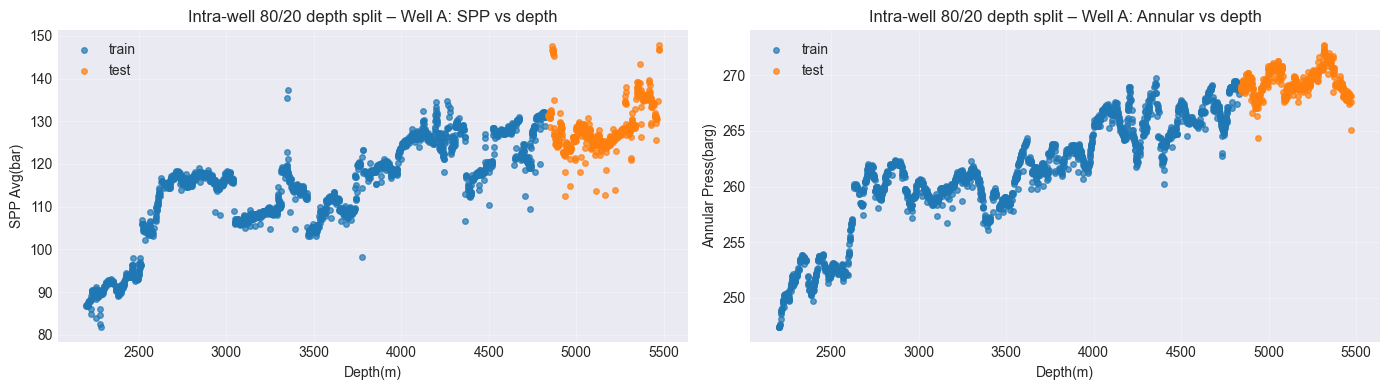

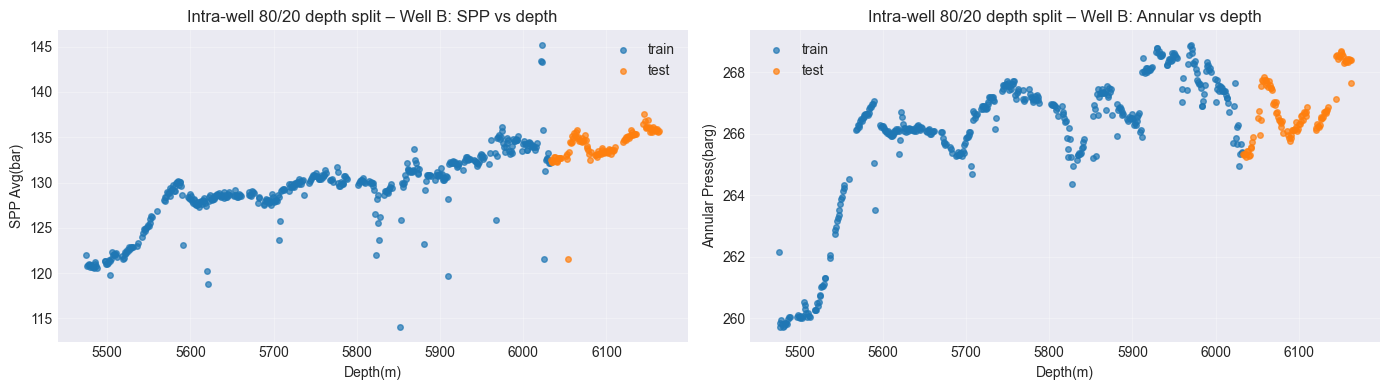

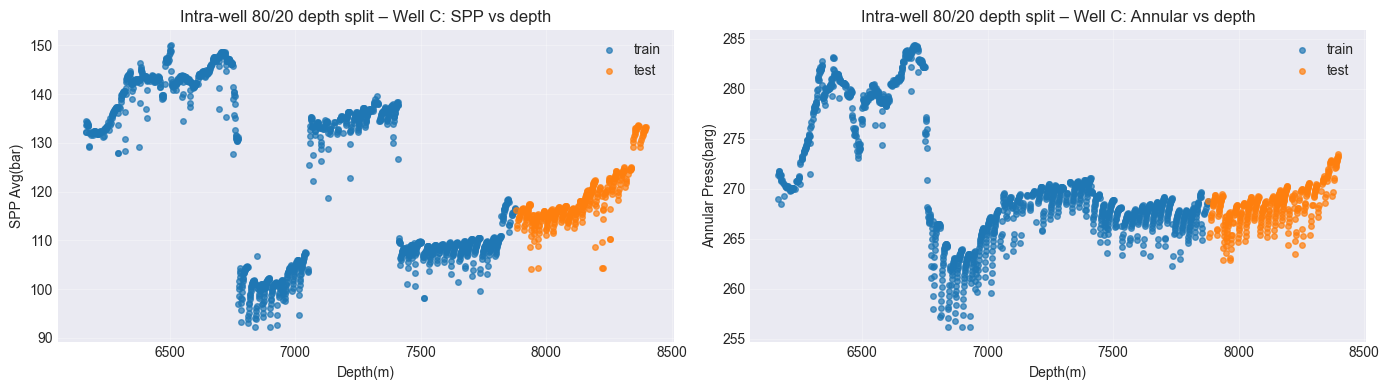

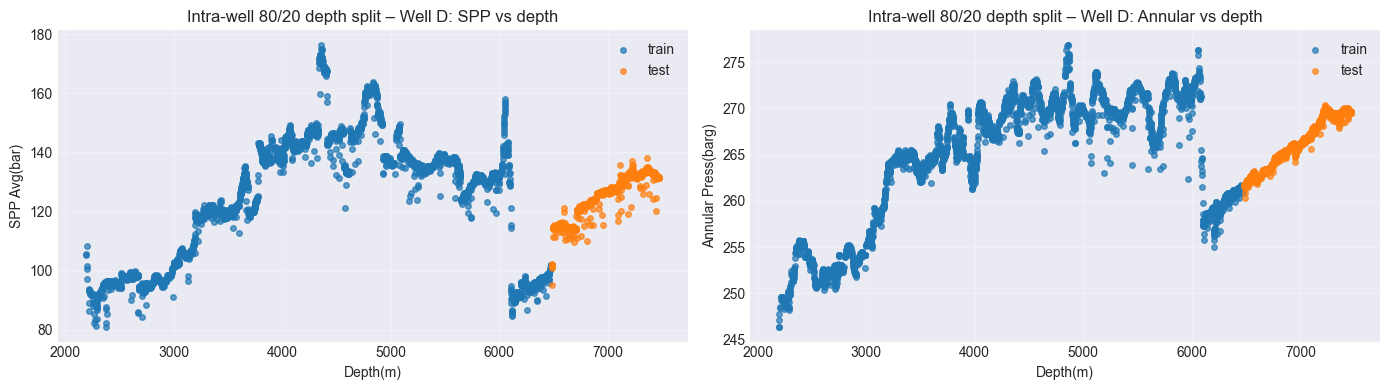

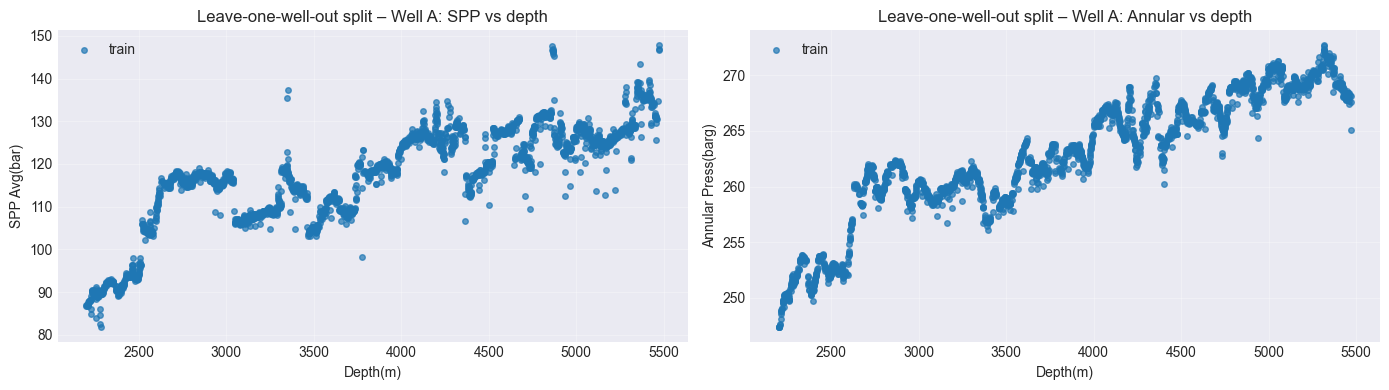

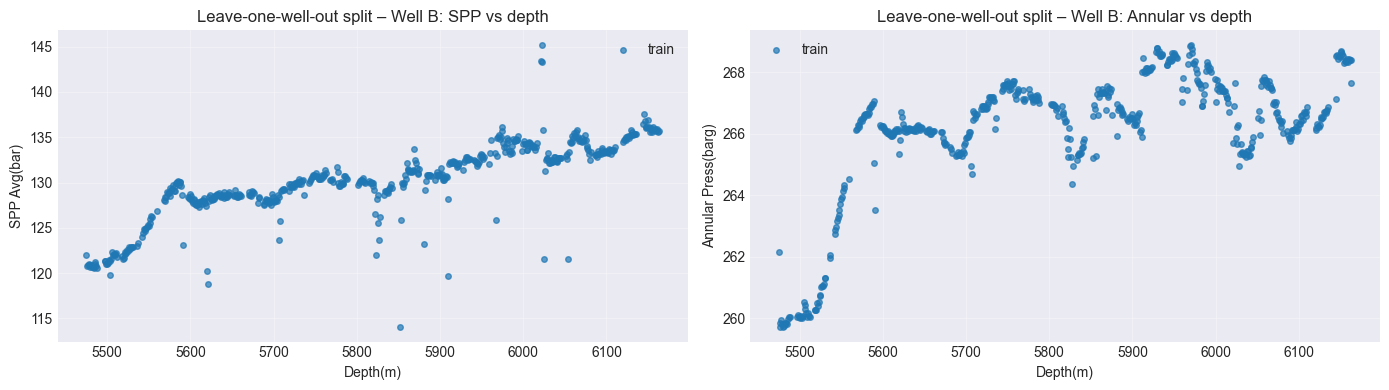

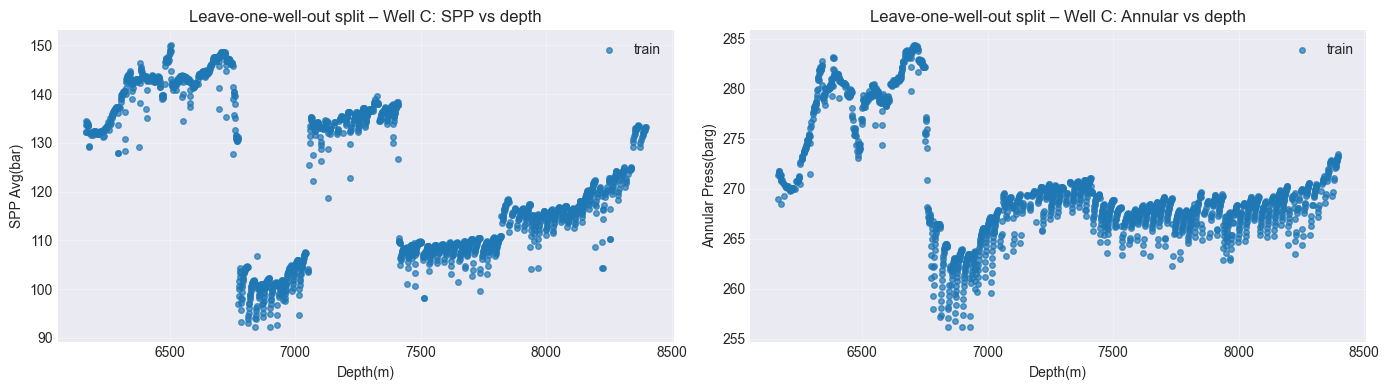

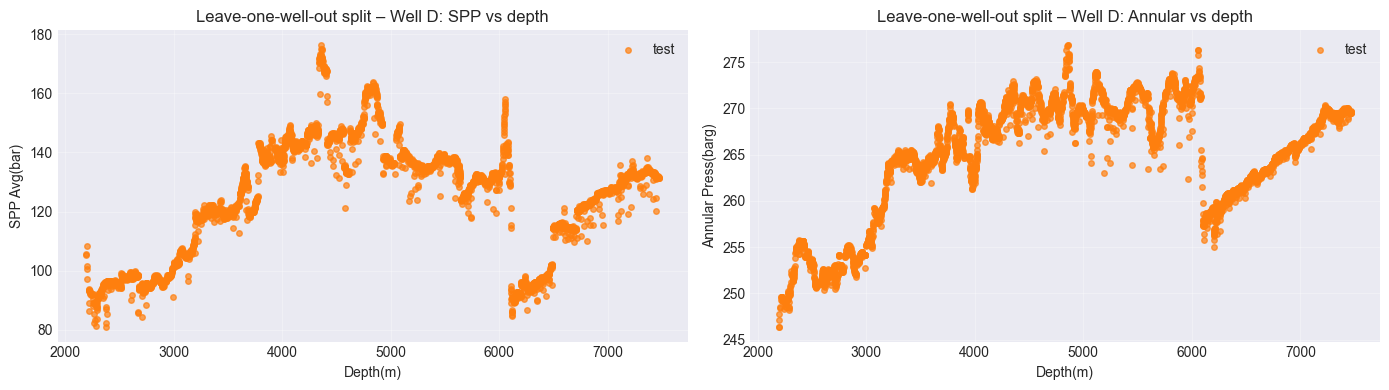

In [8]:
# Visualization of splits: SPP / Annular vs depth colored by split
split_color_map = {"train": "tab:blue", "test": "tab:orange"}

# Helper to plot a split DataFrame per well

def plot_split(df_split: pd.DataFrame, title: str):
    for well_id, df_w in df_split.groupby("well_id"):
        metrics = [(SPP_COL, "SPP"), (ANNULAR_COL, "Annular")]
        metrics = [(c, lbl) for c, lbl in metrics if c in df_w.columns and df_w[c].notna().any()]
        if not metrics:
            continue
        fig, axes = plt.subplots(1, len(metrics), figsize=(7 * len(metrics), 4), sharex=False)
        if len(metrics) == 1:
            axes = [axes]
        for ax, (metric, label) in zip(axes, metrics):
            for split_val, color in split_color_map.items():
                mask = (df_w.get("split") == split_val) & df_w[metric].notna()
                if mask.any():
                    ax.scatter(df_w.loc[mask, DEPTH_COL], df_w.loc[mask, metric], s=16, alpha=0.7, color=color, label=split_val)
            ax.set_title(f"{title} – Well {well_id}: {label} vs depth")
            ax.set_xlabel(DEPTH_COL)
            ax.set_ylabel(metric)
            ax.legend()
            ax.grid(True, alpha=0.3)
        fig.tight_layout()
        plt.show()

# Plot intra-well 80/20 split
plot_split(intra_split_df, title="Intra-well 80/20 depth split")

# Plot leave-one-well-out split
plot_split(loo_split_df, title="Leave-one-well-out split")



In [9]:
print(processed_wells.items())

dict_items([('A',       Depth(m)     TVD(m)  SPP Avg(bar)  Flow In Pum Avg(lpm)  ROP Avg(m/hr)  \
0       2200.0  1975.3170       87.0945             1149.5371        30.0417   
1       2201.0  1975.5159       86.7656             1149.4791        23.9298   
2       2202.0  1975.7328       86.8780             1149.5310        26.0692   
3       2203.0  1975.9408       86.8792             1149.4514        25.5152   
4       2204.0  1976.1558       86.8107             1149.6467        24.8649   
...        ...        ...           ...                   ...            ...   
3268    5468.0  1991.1099      123.8468             1153.7183        45.5393   
3269    5469.0  1991.1038      144.2704             1152.4663        31.1176   
3270    5470.0  1991.0961      146.7295             1152.3182        46.3362   
3271    5471.0  1991.0890      146.9684             1152.2538        29.4006   
3272    5472.0  1991.0825      147.9623             1152.3033        58.6344   

      Torque Abs Avg(